## Business Understanding

### Background

#### There were 107,941 drug-involved overdose deaths reported in the U.S. in 2022; 70% of cases occurred among males (yellow line). Synthetic opioids other than methadone (primarily fentanyl) were the main driver of drug overdose deaths with a over 7.5-fold increase from 2015 to 2022.

### Goal

#### Find ways to identify people through personal traits that are already addicted or are susceptible to make abusive usage of those drugs. Therefore, providing one more tool that health professionals and families alike can use to treat, prevent and help those people to overcome addition.

### The main question

#### What are the personal traits that increases the likelyhood of a person to abuse of heavy drugs (?)?

## Data Source

In [135]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


## Libraries

In [136]:
%pip install tensorflow scikeras scikit-learn
%pip install tensorflow-metal

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [137]:
import pandas as pd
import time
import warnings

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay, precision_recall_curve, roc_curve


import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.metrics import accuracy_score, recall_score, precision_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

In [138]:
# Ignoring warnings
warnings.filterwarnings("ignore")

In [139]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
drug_consumption_quantified = fetch_ucirepo(id=373) 
  
# data (as pandas dataframes) 
X = drug_consumption_quantified.data.features 
y = drug_consumption_quantified.data.targets 

## Data Understanding

In [140]:
# metadata 
for data in drug_consumption_quantified.metadata:
    print(data, ':',drug_consumption_quantified.metadata[data])

uci_id : 373
name : Drug Consumption (Quantified)
repository_url : https://archive.ics.uci.edu/dataset/373/drug+consumption+quantified
data_url : https://archive.ics.uci.edu/static/public/373/data.csv
abstract : Classify type of drug consumer by personality data
area : Social Science
tasks : ['Classification']
characteristics : ['Multivariate']
num_instances : 1885
num_features : 12
feature_types : ['Real']
demographics : ['Age', 'Gender', 'Education Level', 'Nationality', 'Ethnicity']
target_col : ['alcohol', 'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'choc', 'coke', 'crack', 'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 'mushrooms', 'nicotine', 'semer', 'vsa']
index_col : ['id']
has_missing_values : no
missing_values_symbol : None
year_of_dataset_creation : 2015
last_updated : Fri Mar 08 2024
dataset_doi : 10.24432/C5TC7S
creators : ['Elaine Fehrman', 'Vincent Egan', 'Evgeny Mirkes']
intro_paper : {'title': 'The Five Factor Model of personality and evaluation of drug

In [141]:
# variable information 
print(drug_consumption_quantified.variables) 

         name     role         type      demographic description units  \
0          id       ID      Integer             None        None  None   
1         age  Feature   Continuous              Age        None  None   
2      gender  Feature   Continuous           Gender        None  None   
3   education  Feature   Continuous  Education Level        None  None   
4     country  Feature   Continuous      Nationality        None  None   
5   ethnicity  Feature   Continuous        Ethnicity        None  None   
6      nscore  Feature   Continuous             None        None  None   
7      escore  Feature   Continuous             None        None  None   
8      oscore  Feature   Continuous             None        None  None   
9      ascore  Feature   Continuous             None        None  None   
10     cscore  Feature   Continuous             None        None  None   
11  impuslive  Feature   Continuous             None        None  None   
12         ss  Feature   Continuous   

In [142]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1885 non-null   float64
 1   gender     1885 non-null   float64
 2   education  1885 non-null   float64
 3   country    1885 non-null   float64
 4   ethnicity  1885 non-null   float64
 5   nscore     1885 non-null   float64
 6   escore     1885 non-null   float64
 7   oscore     1885 non-null   float64
 8   ascore     1885 non-null   float64
 9   cscore     1885 non-null   float64
 10  impuslive  1885 non-null   float64
 11  ss         1885 non-null   float64
dtypes: float64(12)
memory usage: 176.8 KB


In [143]:
# Checking for null values
X.isnull().sum()

age          0
gender       0
education    0
country      0
ethnicity    0
nscore       0
escore       0
oscore       0
ascore       0
cscore       0
impuslive    0
ss           0
dtype: int64

In [144]:
X.head(5)

age   gender  education  country  ethnicity   nscore   escore   oscore  \
0  0.49788  0.48246   -0.05921  0.96082    0.12600  0.31287 -0.57545 -0.58331   
1 -0.07854 -0.48246    1.98437  0.96082   -0.31685 -0.67825  1.93886  1.43533   
2  0.49788 -0.48246   -0.05921  0.96082   -0.31685 -0.46725  0.80523 -0.84732   
3 -0.95197  0.48246    1.16365  0.96082   -0.31685 -0.14882 -0.80615 -0.01928   
4  0.49788  0.48246    1.98437  0.96082   -0.31685  0.73545 -1.63340 -0.45174   

    ascore   cscore  impuslive       ss  
0 -0.91699 -0.00665   -0.21712 -1.18084  
1  0.76096 -0.14277   -0.71126 -0.21575  
2 -1.62090 -1.01450   -1.37983  0.40148  
3  0.59042  0.58489   -1.37983 -1.18084  
4 -0.30172  1.30612   -0.21712 -0.21575

In [145]:
# Checking for null values
y.isnull().sum()

alcohol      0
amphet       0
amyl         0
benzos       0
caff         0
cannabis     0
choc         0
coke         0
crack        0
ecstasy      0
heroin       0
ketamine     0
legalh       0
lsd          0
meth         0
mushrooms    0
nicotine     0
semer        0
vsa          0
dtype: int64

In [146]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   alcohol    1885 non-null   object
 1   amphet     1885 non-null   object
 2   amyl       1885 non-null   object
 3   benzos     1885 non-null   object
 4   caff       1885 non-null   object
 5   cannabis   1885 non-null   object
 6   choc       1885 non-null   object
 7   coke       1885 non-null   object
 8   crack      1885 non-null   object
 9   ecstasy    1885 non-null   object
 10  heroin     1885 non-null   object
 11  ketamine   1885 non-null   object
 12  legalh     1885 non-null   object
 13  lsd        1885 non-null   object
 14  meth       1885 non-null   object
 15  mushrooms  1885 non-null   object
 16  nicotine   1885 non-null   object
 17  semer      1885 non-null   object
 18  vsa        1885 non-null   object
dtypes: object(19)
memory usage: 279.9+ KB


In [147]:
y.head(5)

alcohol amphet amyl benzos caff cannabis choc coke crack ecstasy heroin  \
0     CL5    CL2  CL0    CL2  CL6      CL0  CL5  CL0   CL0     CL0    CL0   
1     CL5    CL2  CL2    CL0  CL6      CL4  CL6  CL3   CL0     CL4    CL0   
2     CL6    CL0  CL0    CL0  CL6      CL3  CL4  CL0   CL0     CL0    CL0   
3     CL4    CL0  CL0    CL3  CL5      CL2  CL4  CL2   CL0     CL0    CL0   
4     CL4    CL1  CL1    CL0  CL6      CL3  CL6  CL0   CL0     CL1    CL0   

  ketamine legalh  lsd meth mushrooms nicotine semer  vsa  
0      CL0    CL0  CL0  CL0       CL0      CL2   CL0  CL0  
1      CL2    CL0  CL2  CL3       CL0      CL4   CL0  CL0  
2      CL0    CL0  CL0  CL0       CL1      CL0   CL0  CL0  
3      CL2    CL0  CL0  CL0       CL0      CL2   CL0  CL0  
4      CL0    CL1  CL0  CL0       CL2      CL2   CL0  CL0

#### Combining Data

In [148]:
# Combining X and y to facilitate data preparation. Some of the values in the y variable will also be turned into features
df_combined = pd.concat([X, y], axis=1)

In [149]:
# Determining what drugs are considered light drugs
light_drugs = ['nicotine','legalh','choc','caff','alcohol']
len(light_drugs)

5

In [150]:
# Determining what drugs are considered heavy drugs
heavy_drugs = ['crack','vsa','semer','mushrooms','meth','lsd','ketamine','heroin','ecstasy','coke','cannabis','benzos','amyl','amphet']
len(heavy_drugs)

14

In [151]:
# Determine what is abusive usage and/or addition
# CL0   Never Used 
# CL1   Used over a Decade Ago
# CL2   Used in Last Decade
# CL3   Used in Last Yea
# CL4   Used in Last Month
# CL5   Used in Last Week
# CL6   Used in Last Day
heavy_usage_frequency = ['CL3','CL4','CL5','CL6']

In [152]:
# Function to flag users consuming 
# Return 1 if any of the conditions above is True. Otherwise will return 0.
def find_abusive_users(row):
    if (row['crack'] in heavy_usage_frequency or
        row['vsa'] in heavy_usage_frequency or
        row['semer'] in heavy_usage_frequency or
        row['mushrooms'] in heavy_usage_frequency or
        row['meth'] in heavy_usage_frequency or
        row['lsd'] in heavy_usage_frequency or
        row['ketamine'] in heavy_usage_frequency or
        row['heroin'] in heavy_usage_frequency or
        row['ecstasy'] in heavy_usage_frequency or
        row['coke'] in heavy_usage_frequency or
        row['cannabis'] in heavy_usage_frequency or
        row['benzos'] in heavy_usage_frequency or
        row['amyl'] in heavy_usage_frequency or
        row['amphet'] in heavy_usage_frequency
           ):
        return 1
    else:
        return 0

In [153]:
# Creating target column
df_combined.loc[:, "heavy_drugs_user"] = df_combined.apply(find_abusive_users, axis=1)

In [154]:
df_combined.heavy_drugs_user.value_counts()

1    1174
0     711
Name: heavy_drugs_user, dtype: int64

In [155]:
# Dropping columns that identified as part of heavy drugs list
df_combined = df_combined.drop(heavy_drugs, axis=1)

In [156]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1885 non-null   float64
 1   gender            1885 non-null   float64
 2   education         1885 non-null   float64
 3   country           1885 non-null   float64
 4   ethnicity         1885 non-null   float64
 5   nscore            1885 non-null   float64
 6   escore            1885 non-null   float64
 7   oscore            1885 non-null   float64
 8   ascore            1885 non-null   float64
 9   cscore            1885 non-null   float64
 10  impuslive         1885 non-null   float64
 11  ss                1885 non-null   float64
 12  alcohol           1885 non-null   object 
 13  caff              1885 non-null   object 
 14  choc              1885 non-null   object 
 15  legalh            1885 non-null   object 
 16  nicotine          1885 non-null   object 


In [157]:
df_combined.head(5)

age   gender  education  country  ethnicity   nscore   escore   oscore  \
0  0.49788  0.48246   -0.05921  0.96082    0.12600  0.31287 -0.57545 -0.58331   
1 -0.07854 -0.48246    1.98437  0.96082   -0.31685 -0.67825  1.93886  1.43533   
2  0.49788 -0.48246   -0.05921  0.96082   -0.31685 -0.46725  0.80523 -0.84732   
3 -0.95197  0.48246    1.16365  0.96082   -0.31685 -0.14882 -0.80615 -0.01928   
4  0.49788  0.48246    1.98437  0.96082   -0.31685  0.73545 -1.63340 -0.45174   

    ascore   cscore  impuslive       ss alcohol caff choc legalh nicotine  \
0 -0.91699 -0.00665   -0.21712 -1.18084     CL5  CL6  CL5    CL0      CL2   
1  0.76096 -0.14277   -0.71126 -0.21575     CL5  CL6  CL6    CL0      CL4   
2 -1.62090 -1.01450   -1.37983  0.40148     CL6  CL6  CL4    CL0      CL0   
3  0.59042  0.58489   -1.37983 -1.18084     CL4  CL5  CL4    CL0      CL2   
4 -0.30172  1.30612   -0.21712 -0.21575     CL4  CL6  CL6    CL1      CL2   

   heavy_drugs_user  
0                 0  
1                 1  
2                 1  
3                 1  
4                 1

#### Data Visualization

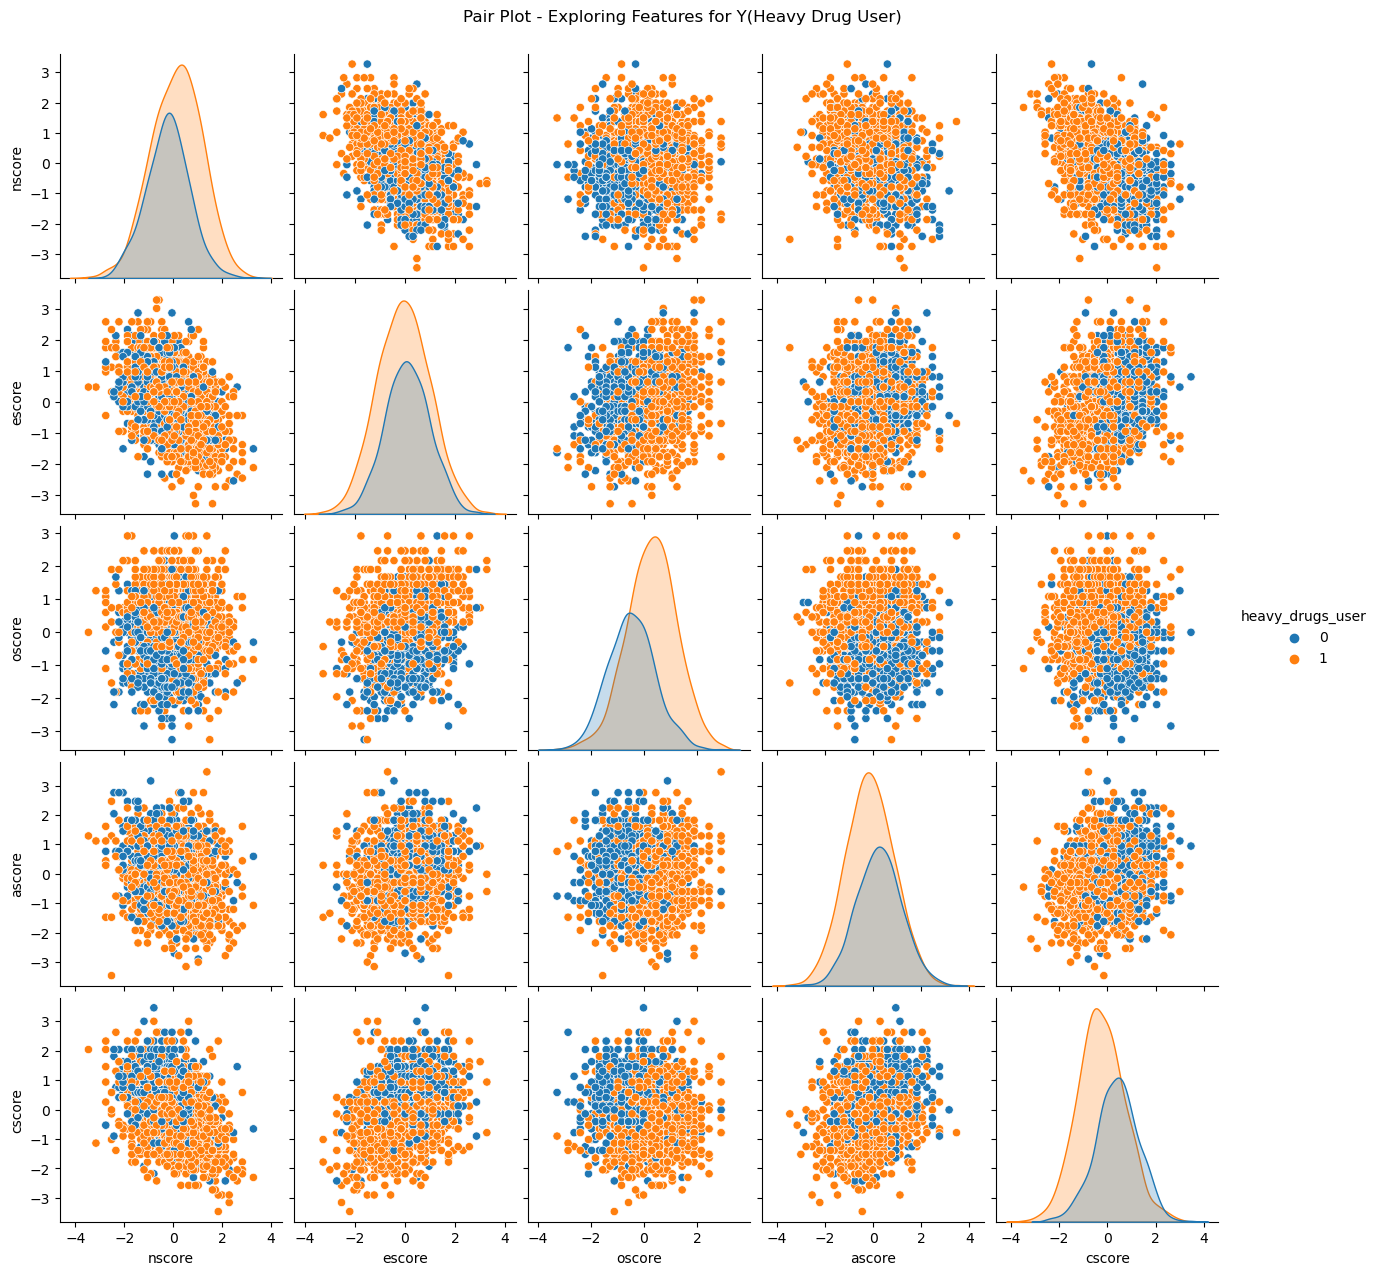

In [158]:
chart = sns.pairplot(df_combined[['heavy_drugs_user','nscore','escore','oscore','ascore','cscore']], hue="heavy_drugs_user")
chart.fig.suptitle("Pair Plot - Exploring Features for Y(Heavy Drug User)", y=1.02)
plt.show()

In [159]:
#       Value    Meaning Cases Fraction
#     -0.95197    18-24   643   34.11%
#     -0.07854    25-34   481   25.52%
#      0.49788    35-44   356   18.89%
#      1.09449    45-54   294   15.60%
#      1.82213    55-64    93    4.93%
#      2.59171    65+      18    0.95%

replace_age = {
    -0.95197: '18-24',
    -0.07854: '25-34',
    0.49788: '35-44',
    1.09449: '45-54',
    1.82213: '55-64',
    2.59171: '65+'
}

fig = px.pie(df_combined.replace(replace_age).groupby('age').size().reset_index(name='count'), values='count', names='age', title='Age Distribution')
fig.show()

In [160]:
fig = px.bar(df_combined.replace(replace_age), x='age', color='heavy_drugs_user', title='Age Distribution Per Drug Abusive User(y)')
fig.show()

In [161]:
#      Value    Meaning Cases Fraction
#      0.48246  Female  942   49.97%
#     -0.48246  Male    943   50.03%

replace_gender = {
    0.48246: 'Female',
    -0.48246: 'Male'
}

fig = px.pie(df_combined.replace(replace_gender).groupby('gender').size().reset_index(name='count'), values='count', names='gender', title='Gender Distribution')
fig.show()

In [162]:
fig = px.bar(df_combined.replace(replace_gender), x='gender', color='heavy_drugs_user', title='Gender Distribution Per Drug Abusive User(y)')
fig.show()

In [163]:
#     Value    Meaning                                              Cases Fraction
#     -2.43591 Left school before 16 years                           28    1.49%
#     -1.73790 Left school at 16 years                               99    5.25%
#     -1.43719 Left school at 17 years                               30    1.59%
#     -1.22751 Left school at 18 years                              100    5.31%
#     -0.61113 Some college or university, no certificate or degree 506   26.84%
#     -0.05921 Professional certificate/ diploma                    270   14.32%
#      0.45468 University degree                                    480   25.46%
#      1.16365 Masters degree                                       283   15.01%
#      1.98437 Doctorate degree                                      89    4.72%

replace_education = {
    -2.43591: 'Left school before 16 years',
    -1.73790: 'Left school at 16 years',
    -1.43719: 'Left school at 17 years',
    -1.22751: 'Left school at 18 years',
    -0.61113: 'Some college or university, no certificate or degree',
    -0.05921: 'Professional certificate/ diploma',
    0.45468: 'University degree',
    1.16365: 'Masters degree',
    1.98437: 'Doctorate degree'
}

fig = px.pie(df_combined.replace(replace_education).groupby('education').size().reset_index(name='count'), values='count', names='education', title='Education Distribution')
fig.show()

In [164]:
fig = px.bar(df_combined.replace(replace_education), x='education', color='heavy_drugs_user', title='Education Distribution Per Drug Abusive User(y)')
fig.show()

In [165]:
#     Value    Meaning             Cases Fraction
#     -0.09765 Australia             54   2.86%
#      0.24923 Canada                87   4.62%
#     -0.46841 New Zealand            5   0.27%
#     -0.28519 Other                118   6.26%
#      0.21128 Republic of Ireland   20   1.06%
#      0.96082 UK                  1044  55.38%
#     -0.57009 USA                  557  29.55%

replace_country = {
    -0.09765: 'Australia',
    0.24923: 'Canada',
    -0.46841: 'New Zealand',
    -0.28519: 'Other',
    0.21128: 'Republic of Ireland',
    0.96082: 'UK',
    -0.57009: 'USA'
}

fig = px.pie(df_combined.replace(replace_country).groupby('country').size().reset_index(name='count'), values='count', names='country', title='Country Distribution')
fig.show()

In [166]:
fig = px.bar(df_combined.replace(replace_country), x='country', color='heavy_drugs_user', title='Country Distribution Per Drug Abusive User(y)')
fig.show()

In [167]:
#     Value    Meaning           Cases Fraction
#     -0.50212 Asian               26   1.38%
#     -1.10702 Black               33   1.75%
#      1.90725 Mixed-Black/Asian    3   0.16%
#      0.12600 Mixed-White/Asian   20   1.06%
#     -0.22166 Mixed-White/Black   20   1.06%
#      0.11440 Other               63   3.34%
#     -0.31685 White             1720  91.25%

replace_ethnicity = {
    -0.50212: 'Asian',
    -1.10702: 'Black',
    1.90725: 'Mixed-Black/Asian',
    0.12600: 'Mixed-White/Asian',
    -0.22166: 'Mixed-White/Black',
    0.11440: 'Other',
    -0.31685: 'White'
}

fig = px.pie(df_combined.replace(replace_ethnicity).groupby('ethnicity').size().reset_index(name='count'), values='count', names='ethnicity', title='Ethnicity Distribution')
fig.show()

In [168]:
fig = px.bar(df_combined.replace(replace_ethnicity), x='ethnicity', color='heavy_drugs_user', title='Ethnicity Distribution Per Drug Abusive User(y)')
fig.show()

In [169]:
# Nscore (Real) is NEO-FFI-R Neuroticism
# Neuroticism (N) is a long-term tendency to experience negative emotions such
# as nervousness, tension, anxiety and depression;
#   Nscore Cases     Value     Nscore Cases     Value     Nscore Cases    Value
#     12      1    -3.46436      29     60    -0.67825      46     67    1.02119
#     13      1    -3.15735      30     61    -0.58016      47     27    1.13281
#     14      7    -2.75696      31     87    -0.46725      48     49    1.23461
#     15      4    -2.52197      32     78    -0.34799      49     40    1.37297
#     16      3    -2.42317      33     68    -0.24649      50     24    1.49158
#     17      4    -2.34360      34     76    -0.14882      51     27    1.60383
#     18     10    -2.21844      35     69    -0.05188      52     17    1.72012
#     19     16    -2.05048      36     73     0.04257      53     20    1.83990
#     20     24    -1.86962      37     67     0.13606      54     15    1.98437
#     21     31    -1.69163      38     63     0.22393      55     11    2.12700
#     22     26    -1.55078      39     66     0.31287      56     10    2.28554
#     23     29    -1.43907      40     80     0.41667      57      6    2.46262
#     24     35    -1.32828      41     61     0.52135      58      3    2.61139
#     25     56    -1.19430      42     77     0.62967      59      5    2.82196
#     26     57    -1.05308      43     49     0.73545      60      2    3.27393
#     27     65    -0.92104      44     51     0.82562
#     28     70    -0.79151      45     37     0.91093

fig = px.bar(df_combined.groupby('nscore').size().reset_index(name='count'), x='nscore', y='count', title='Neuroticism Distribution')
fig.show()

In [170]:
fig = px.box(df_combined, y="nscore", color='heavy_drugs_user', title='Neuroticism Score')
fig.show()

In [171]:
# Escore (Real) is NEO-FFI-R Extraversion
# Extraversion (E) is manifested in outgoing, warm, active, assertive, talkative,
# cheerful, and in search of stimulation characteristics;#
#   Escore Cases    Value      Escore  Cases    Value     Escore Cases    Value
#     16      2    -3.27393      31      55   -1.23177      45     91    0.80523
#     18      1    -3.00537      32      52   -1.09207      46     69    0.96248
#     19      6    -2.72827      33      77   -0.94779      47     64    1.11406
#     20      3    -2.53830      34      68   -0.80615      48     62    1.28610
#     21      3    -2.44904      35      58   -0.69509      49     37    1.45421
#     22      8    -2.32338      36      89   -0.57545      50     25    1.58487
#     23      5    -2.21069      37      90   -0.43999      51     34    1.74091
#     24      9    -2.11437      38     106   -0.30033      52     21    1.93886
#     25      4    -2.03972      39     107   -0.15487      53     15    2.12700
#     26     21    -1.92173      40     130    0.00332      54     10    2.32338
#     27     23    -1.76250      41     116    0.16767      55      9    2.57309
#     28     23    -1.63340      42     109    0.32197      56      2    2.85950
#     29     32    -1.50796      43     105    0.47617      58      1    3.00537
#     30     38    -1.37639      44     103    0.63779      59      2    3.27393

fig = px.bar(df_combined.groupby('escore').size().reset_index(name='count'), x='escore', y='count')
fig.show()

In [172]:
fig = px.box(df_combined, y="escore", color='heavy_drugs_user', title='Extraversion Score')
fig.show()

In [173]:
# Oscore (Real) is NEO-FFI-R Openness to experience
# Openness to experience (O) is a general appreciation for art, unusual ideas, and
# imaginative, creative, unconventional, and wide interests
#Oscore Cases Value         Oscore Cases Value         Oscore Cases Value
#     24      2    -3.27393      38      64   -1.11902      50     83    0.58331
#     26      4    -2.85950      39      60   -0.97631      51     87    0.72330
#     28      4    -2.63199      40      68   -0.84732      52     87    0.88309
#     29     11    -2.39883      41      76   -0.71727      53     81    1.06238
#     30      9    -2.21069      42      87   -0.58331      54     57    1.24033
#     31      9    -2.09015      43      86   -0.45174      55     63    1.43533
#     32     13    -1.97495      44     101   -0.31776      56     38    1.65653
#     33     23    -1.82919      45     103   -0.17779      57     34    1.88511
#     34     25    -1.68062      46     134   -0.01928      58     19    2.15324
#     35     26    -1.55521      47     107    0.14143      59     13    2.44904
#     36     39    -1.42424      48     116    0.29338      60      7    2.90161
#     37     51    -1.27553      49      98    0.44585

fig = px.bar(df_combined.groupby('oscore').size().reset_index(name='count'), x='oscore', y='count')
fig.show()

In [174]:
fig = px.box(df_combined, y="oscore", color='heavy_drugs_user', title='Openness to experience Score')
fig.show()

In [175]:
# Ascore (Real) is NEO-FFI-R Agreeableness
# Agreeableness (A) is a dimension of interpersonal relations, characterized by
# altruism, trust, modesty, kindness, compassion and cooperativeness
#   Ascore Cases     Value     Ascore  Cases    Value     Ascore  Cases   Value
#     12      1    -3.46436      34      42   -1.34289      48     104   0.76096
#     16      1    -3.15735      35      45   -1.21213      49      85   0.94156
#     18      1    -3.00537      36      62   -1.07533      50      68   1.11406
#     23      1    -2.90161      37      83   -0.91699      51      58   1.2861
#     24      2    -2.78793      38      82   -0.76096      52      39   1.45039
#     25      1    -2.70172      39     102   -0.60633      53      36   1.61108
#     26      7    -2.53830      40      98   -0.45321      54      36   1.81866
#     27      7    -2.35413      41     114   -0.30172      55      16   2.03972
#     28      8    -2.21844      42     101   -0.15487      56      14   2.23427
#     29     13    -2.07848      43     105   -0.01729      57       8   2.46262
#     30     18    -1.92595      44     118    0.13136      58       7   2.75696
#     31     24    -1.77200      45     112    0.28783      59       1   3.15735
#     32     30    -1.62090      46     100    0.43852      60       1   3.

fig = px.bar(df_combined.groupby('ascore').size().reset_index(name='count'), x='ascore', y='count')
fig.show()

In [176]:
fig = px.box(df_combined, y="ascore", color='heavy_drugs_user', title='Agreeableness Score')
fig.show()

In [177]:
# Cscore (Real) is NEO-FFI-R Conscientiousness
#   Cscore Cases    Value      Cscore   Cases  Value      Cscore Cases    Value
#     17      1    -3.46436      32       39  -1.25773      46     113   0.58489
#     19      1    -3.15735      33       49  -1.13788      47      95   0.7583
#     20      3    -2.90161      34       55  -1.01450      48      95   0.93949
#     21      2    -2.72827      35       55  -0.89891      49      76   1.13407
#     22      5    -2.57309      36       69  -0.78155      50      47   1.30612
#     23      5    -2.42317      37       81  -0.65253      51      43   1.46191
#     24      6    -2.30408      38       77  -0.52745      52      34   1.63088
#     25      9    -2.18109      39       87  -0.40581      53      28   1.81175
#     26     13    -2.04506      40       97  -0.27607      54      27   2.04506
#     27     13    -1.92173      41       99  -0.14277      55      13   2.33337
#     28     25    -1.78169      42      105  -0.00665      56       8   2.63199
#     29     24    -1.64101      43       90   0.12331      57       3   3.00537
#     30     29    -1.51840      44      111   0.25953      59       1   3.46436
#     31     41    -1.38502      45      111   0.41594    

fig = px.bar(df_combined.groupby('cscore').size().reset_index(name='count'), x='cscore', y='count')
fig.show()

In [178]:
fig = px.box(df_combined, y="cscore", color='heavy_drugs_user', title='Conscientiousness Score')
fig.show()

In [179]:
# Impulsive (Real) is impulsiveness measured by BIS-11
#   Impulsiveness  Cases Fraction
#     -2.55524       20    1.06%
#     -1.37983      276   14.64%
#     -0.71126      307   16.29%
#     -0.21712      355   18.83%
#      0.19268      257   13.63%
#      0.52975      216   11.46%
#      0.88113      195   10.34%
#      1.29221      148    7.85%
#      1.86203      104    5.52%
#      2.90161        7    0.37%

fig = px.pie(df_combined.groupby('impuslive').size().reset_index(name='count'), values='count', names='impuslive', title='Impulsiveness Distribution')
fig.show()

In [180]:
fig = px.box(df_combined, y="impuslive", color='heavy_drugs_user', title='Impulsiveness Score')
fig.show()

In [181]:
# SS (Real) is sensation seeing measured by ImpSS
#         SS  Cases Fraction
#     -2.07848  71    3.77%
#     -1.54858  87    4.62%
#     -1.18084 132    7.00%
#     -0.84637 169    8.97%
#     -0.52593 211   11.19%
#     -0.21575 223   11.83%
#      0.07987 219   11.62%
#      0.40148 249   13.21%
#      0.76540 211   11.19%
#      1.22470 210   11.14%
#      1.92173 103    5.46%

fig = px.pie(df_combined.groupby('ss').size().reset_index(name='count'), values='count', names='ss', title='Sensation Distribution')
fig.show()

In [182]:
fig = px.box(df_combined, y="ss", color='heavy_drugs_user', title='Sensation Score')
fig.show()

In [183]:
# Alcohol is class of alcohol consumption
# Determine what is abusive usage and/or addition
# CL0   Never Used                 1.8%
# CL1   Used over a Decade Ago     1.8%
# CL2   Used in Last Decade        3.61%
# CL3   Used in Last Year          10.5%
# CL4   Used in Last Month         15.2%
# CL5   Used in Last Week          40.3%
# CL6   Used in Last Day           26.8%

replace_drugs_use = {
    'CL0': 'Never Used',
    'CL1': 'Used over a Decade Ago',
    'CL2': 'Used in Last Decade',
    'CL3': 'Used in Last Year',
    'CL4': 'Used in Last Month',
    'CL5': 'Used in Last Week',
    'CL6': 'Used in Last Day'
}

fig = px.pie(df_combined.replace(replace_drugs_use).groupby('alcohol').size().reset_index(name='count'), values='count', names='alcohol', title='Alcohol Distribution')
fig.show()

In [184]:
fig = px.bar(df_combined.replace(replace_drugs_use), x='alcohol', color='heavy_drugs_user', title='Alcohol Distribution Per Drug Abusive User(y)')
fig.show()

In [185]:
# Caff is class of caffeine consumption
# Determine what is abusive usage and/or addition
# CL0   Never Used                 1.43%
# CL1   Used over a Decade Ago     0.53%
# CL2   Used in Last Decade        1.27%
# CL3   Used in Last Year          3.18%
# CL4   Used in Last Month         5.62%
# CL5   Used in Last Week          15.5%
# CL6   Used in Last Day           73.5%

fig = px.pie(df_combined.replace(replace_drugs_use).groupby('caff').size().reset_index(name='count'), values='count', names='caff', title='Caffeine Distribution')
fig.show()

In [186]:
fig = px.bar(df_combined.replace(replace_drugs_use), x='caff', color='heavy_drugs_user', title='Caffeine Distribution Per Drug Abusive User(y)')
fig.show()

In [187]:
# Choc is class of chocolate consumption
# Determine what is abusive usage and/or addition
# CL0   Never Used                 1.7%
# CL1   Used over a Decade Ago     0.16%
# CL2   Used in Last Decade        0.53%
# CL3   Used in Last Year          2.86%
# CL4   Used in Last Month         15.7%
# CL5   Used in Last Week          36.2%
# CL6   Used in Last Day           42.8%

fig = px.pie(df_combined.replace(replace_drugs_use).groupby('choc').size().reset_index(name='count'), values='count', names='choc', title='Chocolate Distribution')
fig.show()

In [188]:
fig = px.bar(df_combined.replace(replace_drugs_use), x='choc', color='heavy_drugs_user', title='Choccolate Distribution Per Drug Abusive User(y)')
fig.show()

In [189]:
# Legalh is class of legal highs consumption
# Determine what is abusive usage and/or addition
# CL0   Never Used                 58%
# CL1   Used over a Decade Ago     1.54%
# CL2   Used in Last Decade        10.5%
# CL3   Used in Last Year          17.1%
# CL4   Used in Last Month         5.84%
# CL5   Used in Last Week          3.4%
# CL6   Used in Last Day           3.55%

fig = px.pie(df_combined.replace(replace_drugs_use).groupby('legalh').size().reset_index(name='count'), values='count', names='legalh', title='Legal Highs Drugs Distribution')
fig.show()

In [190]:
fig = px.bar(df_combined.replace(replace_drugs_use), x='legalh', color='heavy_drugs_user', title='Legal Drugs Distribution Per Drug Abusive User(y)')
fig.show()

In [191]:
# Nicotine is class of nicotine consumption
# Determine what is abusive usage and/or addition
# CL0   Never Used                 22.7%
# CL1   Used over a Decade Ago     10.2%
# CL2   Used in Last Decade        10.8%
# CL3   Used in Last Year          9.81%
# CL4   Used in Last Month         5.73%
# CL5   Used in Last Week          8.33%
# CL6   Used in Last Day           34.4%

fig = px.pie(df_combined.replace(replace_drugs_use).groupby('nicotine').size().reset_index(name='count'), values='count', names='nicotine', title='Nicotine Distribution')
fig.show()

In [192]:
fig = px.bar(df_combined.replace(replace_drugs_use), x='nicotine', color='heavy_drugs_user', title='Nicotine Distribution Per Drug Abusive User(y)')
fig.show()

### Summary of Data Exploration
- Data is skewed in some columns such as country and others
- Some data points seems not to have any predictive power
- Data is already cleaned and ready with OHE applied and numerically scaled
- No missing data
- No further data cleaning necessary
- No further data preprocessing techniques required

## Data Preparation

This dataset is mostly cleaned already scaled with median near 0. The data is ready to be modeled.

#### Splitting Data

In [193]:
X_train, X_test, y_train, y_test = train_test_split(df_combined.drop('heavy_drugs_user', axis=1), df_combined['heavy_drugs_user'], random_state = 1234)

### Feature Engineering

In [194]:
col = make_column_transformer(
    (OrdinalEncoder(categories = [['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'],['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'],['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'],['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'],['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6']]), ['alcohol','caff','choc','legalh','nicotine'])
    , remainder='passthrough'
)

In [195]:
X_train_scaled = col.fit_transform(X_train[['alcohol','caff','choc','legalh','nicotine']])
X_test_scaled = col.fit_transform(X_test[['alcohol','caff','choc','legalh','nicotine']])
X_train_scaled

array([[5., 6., 6., 0., 2.],
       [5., 6., 4., 1., 6.],
       [6., 6., 5., 0., 4.],
       ...,
       [4., 5., 4., 3., 0.],
       [5., 6., 6., 3., 3.],
       [4., 4., 4., 2., 3.]])

### Baseline Model
#### Dump model to be beat

In [196]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train,y_train)
y_baseline_pred = dummy_clf.predict(X_train)
baseline_accuracy = accuracy_score(y_baseline_pred, y_train)
baseline_accuracy_test = accuracy_score(dummy_clf.predict(X_test), y_test)

print(f'The baseline accuracy to beat is {baseline_accuracy}')

The baseline accuracy to beat is 0.6319886765746638


###  Initial Modeling
##### No hyperparameter tuning

In [197]:
# LogisticRegression
pipe_logreg = Pipeline([
    ('coltrans', col),
    ('logreg', LogisticRegression(random_state=1234))
])

start_time = time.time()
pipe_logreg.fit(X_train, y_train)
end_time = time.time()
pipe_logreg_fitting_time = end_time - start_time

# Accuracy
pipe_logreg_train_acc = accuracy_score(pipe_logreg.predict(X_train), y_train)
pipe_logreg_test_acc = accuracy_score(pipe_logreg.predict(X_test), y_test)

pipe_logreg

Pipeline(steps=[('coltrans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6'],
                                                                             ['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6'],
                                                                             ['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6'],
                                                                             ['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6'],
                                                                             ['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6']]),
                                                  ['alcohol', 'caff', 'choc',
                                                   'legalh', 'nicotine'])])),
                ('logreg', LogisticRegression(random_state=1234))])

In [198]:
# KNeighborsClassifier
pipe_knn = Pipeline([
    ('coltrans', col),
    ('knn', KNeighborsClassifier())
])

start_time = time.time()
pipe_knn.fit(X_train, y_train)
end_time = time.time()
pipe_knn_fitting_time = end_time - start_time

# Accuracy
pipe_knn_train_acc = accuracy_score(pipe_knn.predict(X_train), y_train)
pipe_knn_test_acc = accuracy_score(pipe_knn.predict(X_test), y_test)

pipe_knn

Pipeline(steps=[('coltrans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6'],
                                                                             ['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6'],
                                                                             ['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6'],
                                                                             ['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6'],
                                                                             ['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6']]),
                                                  ['alcohol', 'caff', 'choc',
                                                   'legalh', 'nicotine'])])),
                ('knn', KNeighborsClassifier())])

In [199]:
# DecisionTreeClassifier
pipe_dt = Pipeline([
    ('coltrans', col),
    ('dt', DecisionTreeClassifier(random_state=1234))
])

start_time = time.time()
pipe_dt.fit(X_train, y_train)
end_time = time.time()
pipe_dt_fitting_time = end_time - start_time

# Accuracy
pipe_dt_train_acc = accuracy_score(pipe_dt.predict(X_train), y_train)
pipe_dt_test_acc = accuracy_score(pipe_dt.predict(X_test), y_test)

pipe_dt

Pipeline(steps=[('coltrans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6'],
                                                                             ['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6'],
                                                                             ['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6'],
                                                                             ['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6'],
                                                                             ['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6']]),
                                                  ['alcohol', 'caff', 'choc',
                                                   'legalh', 'nicotine'])])),
                ('dt', DecisionTreeClassifier(random_state=1234))])

In [200]:
# SVC
pipe_svc = Pipeline([
    ('coltrans', col),
    ('svc', SVC(random_state=1234))
])

start_time = time.time()
pipe_svc.fit(X_train, y_train)
end_time = time.time()
pipe_svc_fitting_time = end_time - start_time

# Accuracy
pipe_svc_train_acc = accuracy_score(pipe_svc.predict(X_train), y_train)
pipe_svc_test_acc = accuracy_score(pipe_svc.predict(X_test), y_test)

pipe_svc

Pipeline(steps=[('coltrans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6'],
                                                                             ['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6'],
                                                                             ['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6'],
                                                                             ['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6'],
                                                                             ['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6']]),
                                                  ['alcohol', 'caff', 'choc',
                                                   'legalh', 'nicotine'])])),
                ('svc', SVC(random_state=1234))])

In [201]:
# RandomForestClassifier
pipe_rfc = Pipeline([
    ('coltrans', col),
    ('rfc', RandomForestClassifier())
])

start_time = time.time()
pipe_rfc.fit(X_train, y_train)
end_time = time.time()
pipe_rfc_fitting_time = end_time - start_time

# Accuracy
pipe_rfc_train_acc = accuracy_score(pipe_rfc.predict(X_train), y_train)
pipe_rfc_test_acc = accuracy_score(pipe_rfc.predict(X_test), y_test)

pipe_rfc

Pipeline(steps=[('coltrans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6'],
                                                                             ['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6'],
                                                                             ['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6'],
                                                                             ['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6'],
                                                                             ['CL0',
                                                                              'CL1',
                                                                              'CL2',
                                                                              'CL3',
                                                                              'CL4',
                                                                              'CL5',
                                                                              'CL6']]),
                                                  ['alcohol', 'caff', 'choc',
                                                   'legalh', 'nicotine'])])),
                ('rfc', RandomForestClassifier())])

In [202]:
# KerasClassifier

def build_function(optimizer = 'adam', 
                  loss = 'binary_crossentropy', metrics = ['accuracy']):
    
    model = Sequential([
        Dense(5, input_dim=X_train_scaled.shape[1], activation='relu'),
        Dense(5, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=optimizer,
        metrics = metrics,
        loss = loss
    )
    
    return model

tf.random.set_seed(42)

model = build_function()
model.summary()


start_time = time.time()
history = model.fit(X_train_scaled, y_train, epochs=3, validation_data=(X_test_scaled, y_test))
end_time = time.time()
model_keras_class_fitting_time = end_time - start_time

# Accuracy
model_kerasclass_train_acc = history.history['accuracy'][-1]
model_kerasclass_test_acc = history.history['val_accuracy'][-1]

Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_276 (Dense)               │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_277 (Dense)               │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_278 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3683 - loss: 0.7133 - val_accuracy: 0.4788 - val_loss: 0.6933
Epoch 2/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5387 - loss: 0.6911 - val_accuracy: 0.6547 - val_loss: 0.6804
Epoch 3/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7394 - loss: 0.6686 - val_accuracy: 0.7500 - val_loss: 0.6445


In [203]:
model_comparison_dict = {'Models': ['Baseline Model','Logistic Regression', 'KNN', 'Decision Tree', 'SVC', 'RandomForest Classifier', 'Keras Classifier'],
                   'Train Time': [0,pipe_logreg_fitting_time, pipe_knn_fitting_time, pipe_dt_fitting_time, pipe_svc_fitting_time, pipe_rfc_fitting_time, model_keras_class_fitting_time],
                   'Train Accuracy': [baseline_accuracy, pipe_logreg_train_acc, pipe_knn_train_acc, pipe_dt_train_acc, pipe_svc_train_acc, pipe_rfc_train_acc, model_kerasclass_train_acc],
                   'Test Accuracy': [baseline_accuracy_test,pipe_logreg_test_acc, pipe_knn_test_acc, pipe_dt_test_acc, pipe_svc_test_acc, pipe_rfc_test_acc, model_kerasclass_test_acc]}

model_comparison_df = pd.DataFrame(model_comparison_dict)
model_comparison_df

Models  Train Time  Train Accuracy  Test Accuracy
0           Baseline Model    0.000000        0.631989       0.595339
1      Logistic Regression    0.197306        0.875442       0.853814
2                      KNN    0.011849        0.880396       0.832627
3            Decision Tree    0.007452        1.000000       0.813559
4                      SVC    0.017699        0.881104       0.858051
5  RandomForest Classifier    0.115868        1.000000       0.868644
6         Keras Classifier    2.320721        0.755839       0.750000

In [204]:
fig = px.bar(model_comparison_df.sort_values(by='Test Accuracy', ascending=False), x='Models', y='Test Accuracy', title='Model Acuracy Comparison in Test (Ordered by Best Model to Worse)')
fig.show()

###  Tuning Model With Hyperparameters

In [205]:
# Logistic Regressions
params_logreg = {'logreg__penalty': [None, 'l2', 'l1', 'elasticnet'],
          'logreg__fit_intercept': [True, False]}

grid_pipe_logreg = GridSearchCV(
    estimator = pipe_logreg,
    param_grid = params_logreg,
    cv = 5
)

grid_pipe_logreg.fit(X_train, y_train)
grid_pipe_logreg_meanfit_time = grid_pipe_logreg.cv_results_['mean_fit_time'].mean()

# Accuracy
grid_pipe_logreg_train_acc = accuracy_score(grid_pipe_logreg.best_estimator_.predict(X_train), y_train)
grid_pipe_logreg_test_acc = accuracy_score(grid_pipe_logreg.best_estimator_.predict(X_test), y_test)

grid_pipe_logreg

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('coltrans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                                                     'CL6'],
                                                                                                    ['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                                                     'CL6'],
                                                                                                    ['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                                                     'CL6'],
                                                                                                    ['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                                                     'CL6'],
                                                                                                    ['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                               

In [206]:
# KNeighborsClassifier Accuracy
params_knn = {'knn__n_neighbors': [1,2,3,4,5,6,7,8],
          'knn__weights': ['uniform', 'distance']}

grid_pipe_knn = GridSearchCV(
    estimator = pipe_knn,
    param_grid = params_knn,
    cv = 5
)

grid_pipe_knn.fit(X_train, y_train)
grid_pipe_knn_meanfit_time = grid_pipe_knn.cv_results_['mean_fit_time'].mean()

# Accuracy
grid_pipe_knn_train_acc = accuracy_score(grid_pipe_knn.best_estimator_.predict(X_train), y_train)
grid_pipe_knn_test_acc = accuracy_score(grid_pipe_knn.best_estimator_.predict(X_test), y_test)

grid_pipe_knn

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('coltrans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                                                     'CL6'],
                                                                                                    ['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                                                     'CL6'],
                                                                                                    ['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                                                     'CL6'],
                                                                                                    ['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                                                     'CL6'],
                                                                                                    ['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                               

In [207]:
# DecisionTreeClassifier
params_dt = {'dt__criterion': ['gini','entropy','log_loss'],
             'dt__splitter': ['best','random'],
             'dt__max_depth': [4, 5, 6, 7, 8, None]}

grid_pipe_dt = GridSearchCV(
    estimator = pipe_dt,
    param_grid = params_dt,
    cv = 5
)
             
grid_pipe_dt.fit(X_train, y_train)   
grid_pipe_dt_meanfit_time = grid_pipe_dt.cv_results_['mean_fit_time'].mean()

# Accuracy
grid_pipe_dt_train_acc = accuracy_score(grid_pipe_dt.best_estimator_.predict(X_train), y_train)
grid_pipe_dt_test_acc = accuracy_score(grid_pipe_dt.best_estimator_.predict(X_test), y_test)

grid_pipe_dt

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('coltrans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                                                     'CL6'],
                                                                                                    ['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                                                     'CL6'],
                                                                                                    ['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                                                     'CL6'],
                                                                                                    ['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                                                     'CL6'],
                                                                                                    ['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                               

In [208]:
# SVC
params_svc = {'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
          'svc__degree': [1,2,3,4],
          'svc__gamma': ['scale','auto']}

grid_pipe_svc = GridSearchCV(
    estimator = pipe_svc,
    param_grid = params_svc,
    cv = 5
)

grid_pipe_svc.fit(X_train, y_train)
grid_pipe_svc_meanfit_time = grid_pipe_svc.cv_results_['mean_fit_time'].mean()

# Accuracy
grid_pipe_svc_train_acc = accuracy_score(grid_pipe_svc.best_estimator_.predict(X_train), y_train)
grid_pipe_svc_test_acc = accuracy_score(grid_pipe_svc.best_estimator_.predict(X_test), y_test)

grid_pipe_svc

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('coltrans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                                                     'CL6'],
                                                                                                    ['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                                                     'CL6'],
                                                                                                    ['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                                                     'CL6'],
                                                                                                    ['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                                                     'CL6'],
                                                                                                    ['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                               

In [209]:
# RandomForestClassifier
params_rfc = {'rfc__n_estimators': [100, 150, 170, 200, 250],
          'rfc__criterion': ['gini', 'entropy', 'log_loss'],
          'rfc__max_depth': [4, 5, 6, 7, None]}

grid_pipe_rfc = GridSearchCV(
    estimator = pipe_rfc,
    param_grid = params_rfc,
    cv = 5
)

grid_pipe_rfc.fit(X_train, y_train)
grid_pipe_rfc_meanfit_time = grid_pipe_rfc.cv_results_['mean_fit_time'].mean()

# Accuracy
grid_pipe_rfc_train_acc = accuracy_score(grid_pipe_rfc.best_estimator_.predict(X_train), y_train)
grid_pipe_rfc_test_acc = accuracy_score(grid_pipe_rfc.best_estimator_.predict(X_test), y_test)

grid_pipe_rfc

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('coltrans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                                                     'CL6'],
                                                                                                    ['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                                                     'CL6'],
                                                                                                    ['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                                                     'CL6'],
                                                                                                    ['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                                                     'CL6'],
                                                                                                    ['CL0',
                                                                                                     'CL1',
                                                                                                     'CL2',
                                                                                                     'CL3',
                                                                                                     'CL4',
                                                                                                     'CL5',
                                                                               

In [210]:
# KerasClassifier

model_keras_class = KerasClassifier(model=build_function, epochs=5, verbose = 0)

# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
#init = ['glorot_uniform', 'normal', 'uniform']
epochs = [7, 10, 15]
batches = [3, 5, 10]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches) #, model__init=init

grid_keras_class = GridSearchCV(estimator=model_keras_class, param_grid=param_grid)

grid_keras_class.fit(X_train_scaled, y_train)

grid_keras_class_meanfit_time = grid_keras_class.cv_results_['mean_fit_time'].mean()

# Accuracy
grid_keras_class_train_acc = accuracy_score(grid_keras_class.best_estimator_.predict(X_train_scaled), y_train)
grid_keras_class_test_acc = accuracy_score(grid_keras_class.best_estimator_.predict(X_test_scaled), y_test)

grid_keras_class

GridSearchCV(estimator=KerasClassifier(epochs=5, model=<function build_function at 0x3795b7130>, verbose=0),
             param_grid={'batch_size': [3, 5, 10], 'epochs': [7, 10, 15],
                         'optimizer': ['rmsprop', 'adam']})

In [212]:
grid_pipe_param_dict = {'Models': ['Grid Logistic Regression', 'Grid KNN', 'Grid Decision Tree', 'Grid SVC', 'Grid RandomForest Classifier', 'Grid Keras Classifier'],
                    'Train Time': [grid_pipe_logreg_meanfit_time, grid_pipe_knn_meanfit_time, grid_pipe_dt_meanfit_time, grid_pipe_svc_meanfit_time, grid_pipe_rfc_meanfit_time, grid_keras_class_meanfit_time],
                   'Train Accuracy': [grid_pipe_logreg_train_acc, grid_pipe_knn_train_acc, grid_pipe_dt_train_acc, grid_pipe_svc_train_acc, grid_pipe_rfc_train_acc, grid_keras_class_train_acc],
                   'Test Accuracy': [grid_pipe_logreg_test_acc, grid_pipe_knn_test_acc, grid_pipe_dt_test_acc, grid_pipe_svc_test_acc, grid_pipe_rfc_test_acc, grid_keras_class_test_acc]}

grid_pipe_param = pd.DataFrame(grid_pipe_param_dict)
grid_pipe_param

Models  Train Time  Train Accuracy  Test Accuracy
0      Grid Logistic Regression    0.007045        0.874735       0.853814
1                      Grid KNN    0.002591        0.880396       0.832627
2            Grid Decision Tree    0.003514        0.881104       0.838983
3                      Grid SVC    0.018028        0.872611       0.851695
4  Grid RandomForest Classifier    0.130595        0.898089       0.855932
5         Grid Keras Classifier   15.611827        0.823779       0.790254

In [213]:
fig = px.bar(grid_pipe_param.sort_values(by='Test Accuracy', ascending=False), x='Models', y='Test Accuracy', title='Model Acuracy Comparison in Test (Ordered by Best Model to Worse)')
fig.show()

### Exploring top 2 performant models
#### Confusion Matrix
1. Random Forest Classifier

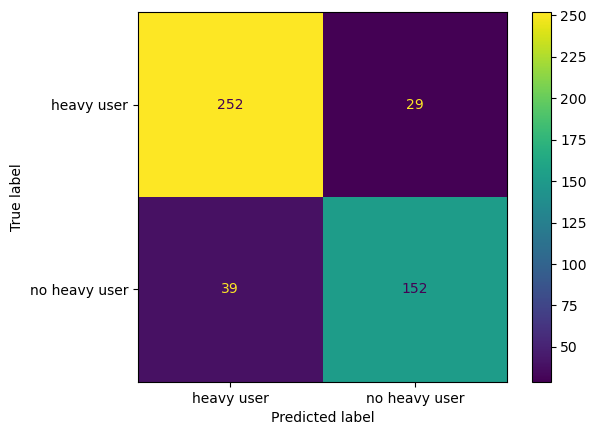

In [214]:
churn_confusion_mat = confusion_matrix(y_test, grid_pipe_rfc.best_estimator_.predict(X_test), labels=[1, 0])

disp = ConfusionMatrixDisplay(confusion_matrix=churn_confusion_mat,
                               display_labels=['heavy user', 'no heavy user'])

disp.plot()
plt.show()

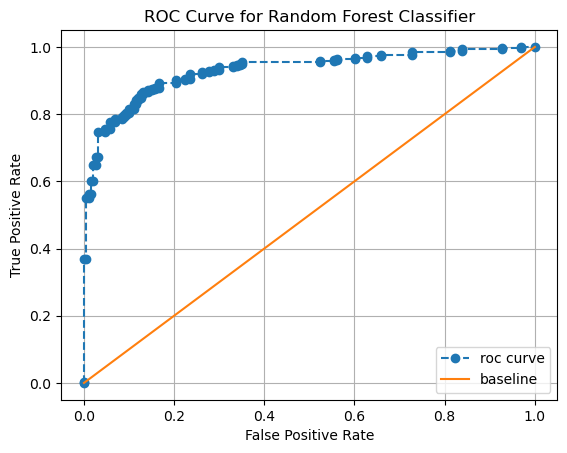

In [215]:
scores = grid_pipe_rfc.best_estimator_.predict_proba(X_test)[:,1]
fpr, tpr, thresh_rocs = '', '', ''
fpr, tpr, thresh_rocs = roc_curve(y_test.values, scores)

# Answer check
plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label = 'baseline')
plt.legend()
plt.title('ROC Curve for Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();


2. Logistic Regression

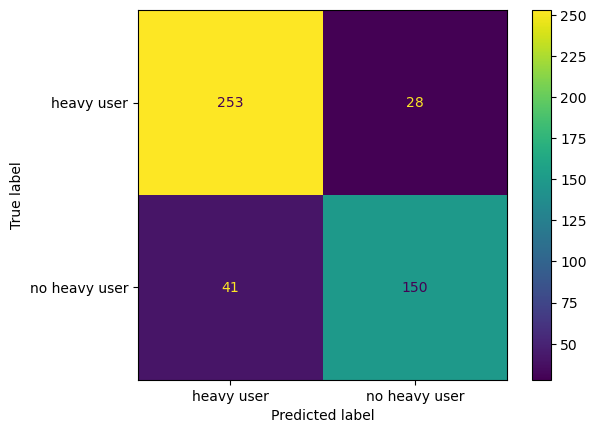

In [216]:
churn_confusion_mat = confusion_matrix(y_test, grid_pipe_logreg.best_estimator_.predict(X_test), labels=[1, 0])

disp = ConfusionMatrixDisplay(confusion_matrix=churn_confusion_mat,
                               display_labels=['heavy user', 'no heavy user'])

disp.plot()
plt.show()

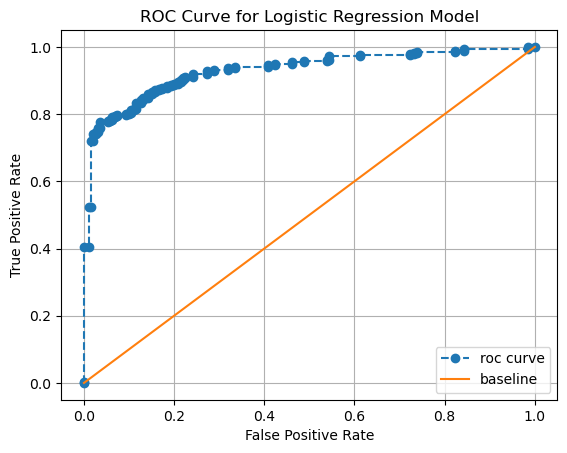

In [217]:
scores = grid_pipe_logreg.best_estimator_.predict_proba(X_test)[:,1]
fpr, tpr, thresh_rocs = '', '', ''
fpr, tpr, thresh_rocs = roc_curve(y_test.values, scores)

# Answer check
plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label = 'baseline')
plt.legend()
plt.title('ROC Curve for Logistic Regression Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();


### Confusion Matrix Analysis Summary
The Random Forest  model offers similar true positives as the logistic regression one, however, it performs much better on false positives and true negatives. Therefore, a better model.

#### What is the relevance for False positive Versus True positive in the context of this study?
Even though we cannot assign hard numbers to cost False Positive and False Negative we can analyze at a high level what they mean in the context of this research.

##### False Positive
A false positive would make a doctor be reluctant to prescribe a given high aditive drug to a patient and eventual refer him/her to psichiatric treatment to further analyze the most relevant risk factors to abusive such drugs.

While this whole process could be seen as incovenient and more bureautic the extra care here might be able to mitigate the risk of a much more expensive scenario - finantially and emotionally - in which a patient became adctive to a drug and keep consuming for a longer term which could evolve to abusive other drugs too. This is bad for medical practioners, patients and health insurance companies alike.

##### False Negative
A false negative would have the worse consequences as the ones described for "False Postive" above. That's because a patient that is vulnerable to abusive certain drugs will be exposed to that without any flaf to the doctor responsible for their treatment. This could lead to disastraous consequences in the lifes of the patients should they develop adiction to those drugs. 

### Model Interpretation

#### Best model chosen: Random Forest Classifier

Text(0.5, 1.0, 'Permutation Importance with Standard Deviation')

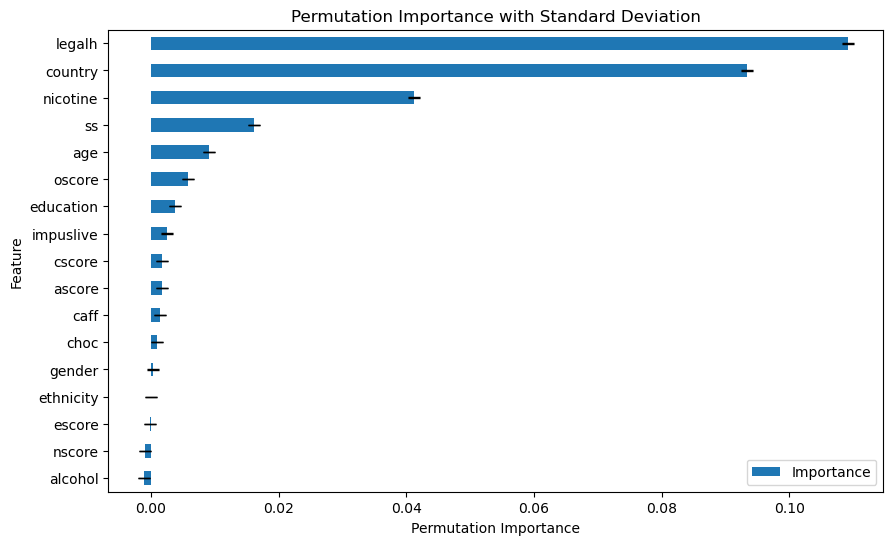

In [218]:
model = grid_pipe_rfc.best_estimator_

result = permutation_importance(model, X_test, y_test, n_repeats=20, random_state=42)


feature_importance = pd.DataFrame({'Feature': X_train.columns,
                                   'Importance': result.importances_mean,
                                   'Standard Deviation': result.importances_std})
feature_importance = feature_importance.sort_values('Importance', ascending=True)


ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), yerr='Standard Deviation', capsize=4)
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance with Standard Deviation')
